In [1]:
import pandas as pd
import numpy as np

In [2]:
behavior = pd.read_csv('TASK2_DS_behavior.csv', sep=';')
behaviorII = pd.read_csv('TASK2_DS_behaviorII.csv', sep=';')
feedback = pd.read_csv('TASK2_DS_feedback.csv', sep=';')

In [3]:
behavior_data = pd.concat([behavior,behaviorII])

In [4]:
behavior_data['BeginDate'] = pd.to_datetime(behavior_data['BeginDate'])
behavior_data['EndDate'] = pd.to_datetime(behavior_data['EndDate'])

In [5]:
behavior_data['OKVED'] = behavior_data['OKVED'].fillna(0.0)
behavior_data['OKVED'] = behavior_data['OKVED'].astype(int)

In [6]:
def get_last_n_behavior_by_user(
    df, n, min_ratings_per_user=1, user_colname="UID", timestamp_colname="BeginDate"
):
    return (
        df.groupby(user_colname)
        .filter(lambda x: len(x) >= min_ratings_per_user)
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )

In [7]:
behavior_data.drop_duplicates(['UID']).shape

(6194, 11)

In [8]:
sequence_length = 50

In [9]:
behavior_data['Action_Caption'] = behavior_data['Action'] + ' ' + behavior_data['Caption']

In [10]:
behavior_data_prep = get_last_n_behavior_by_user(behavior_data, sequence_length)

In [11]:
grouped_behavior = behavior_data_prep.sort_values(by='BeginDate').groupby('UID').agg(tuple).reset_index()

In [12]:
def create_sequences(values, sequence_length):
    sequences = []
    for i, v in enumerate(values):
        seq = values[:i+1]
        if len(seq) > sequence_length:
            seq = seq[i-sequence_length+1:i+1]
        elif len(seq) < sequence_length:
            seq =(*(['[PAD]'] * (sequence_length - len(seq))), *seq)

        sequences.append(seq)
    return sequences

In [13]:
grouped_cols = ['OKVED', 'Action_Caption']
for col in grouped_cols:
    grouped_behavior[col] = grouped_behavior[col].apply(lambda x: create_sequences(x, sequence_length))

In [14]:
grouped_behavior.columns

Index(['UID', 'UnitType', 'OKVED', 'Action', 'Caption', 'BeginDate', 'EndDate',
       'nCount', 'Amount', 'Volume', 'Weight', 'Action_Caption'],
      dtype='object')

In [15]:
grouped_behavior['UnitType'] = grouped_behavior['UnitType'].apply(lambda x: x[0])

In [16]:
grouped_behavior['Amount'] = grouped_behavior['Amount'].apply(lambda x: np.array(x)[~np.isnan(np.array(x))].mean())
grouped_behavior['Volume'] = grouped_behavior['Volume'].apply(lambda x: np.array(x)[~np.isnan(np.array(x))].mean())
grouped_behavior['Weight'] = grouped_behavior['Weight'].apply(lambda x: np.array(x)[~np.isnan(np.array(x))].mean())

C:\Users\Владислав\AppData\Local\Temp\ipykernel_10092\2637723014.py:2: RuntimeWarning: Mean of empty slice.
  grouped_behavior['Volume'] = grouped_behavior['Volume'].apply(lambda x: np.array(x)[~np.isnan(np.array(x))].mean())
C:\ProgramData\Anaconda3\envs\pytorch_env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Владислав\AppData\Local\Temp\ipykernel_10092\2637723014.py:3: RuntimeWarning: Mean of empty slice.
  grouped_behavior['Weight'] = grouped_behavior['Weight'].apply(lambda x: np.array(x)[~np.isnan(np.array(x))].mean())


In [17]:
feedback['all_action'] = feedback['nClick']+feedback['nOpen']+feedback['nSend']

In [18]:
feedback['rating'] = (feedback['nClick']*5 +feedback['nOpen'])/feedback['all_action']

<Axes: >

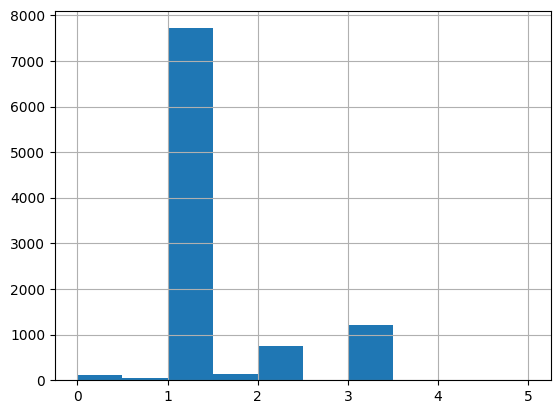

In [19]:
feedback.rating.hist()

In [20]:
def make_rating(x):
  if x < 1:
    return 1
  elif x == 1:
    return 2
  elif x > 1 and x < 3:
    return 3
  else:
    return 4

In [21]:
feedback['rating_cut'] = feedback.rating.apply(lambda x: make_rating(x))

In [22]:
feedback.rating.unique()

array([1.        , 2.33333333, 3.        , 0.        , 1.8       ,
       2.        , 0.5       , 1.66666667, 2.6       , 2.71428571,
       1.57142857, 2.14285714, 1.88888889, 0.66666667, 3.66666667,
       5.        , 1.44444444, 1.5       , 2.5       ])

In [23]:
grouped_behavior['Amount'] = grouped_behavior['Amount'].fillna(grouped_behavior['Amount'].median())
grouped_behavior['Volume'] = grouped_behavior['Volume'].fillna(grouped_behavior['Volume'].median())
grouped_behavior['Weight'] = grouped_behavior['Weight'].fillna(grouped_behavior['Weight'].median())

In [24]:
grouped_behavior['Amount'] = (grouped_behavior['Amount']-grouped_behavior['Amount'].mean())/grouped_behavior['Amount'].std()
grouped_behavior['Volume'] = (grouped_behavior['Volume']-grouped_behavior['Volume'].mean())/grouped_behavior['Volume'].std()
grouped_behavior['Weight'] = (grouped_behavior['Weight']-grouped_behavior['Weight'].mean())/grouped_behavior['Weight'].std()

In [25]:
exploded_behavior = grouped_behavior[['UID', 'UnitType', 'Amount', 'Volume', 'Weight', 'OKVED']].explode('OKVED', ignore_index=True)
dfs = [grouped_behavior[[col]].explode(col, ignore_index=True) for col in grouped_cols[1:]]
seq_df = pd.concat([exploded_behavior, *dfs], axis=1)

In [26]:
seq_df = seq_df.merge(feedback, how='inner', on='UID')

In [27]:
def create_feature_lookup(df, feature):
    lookup = {v: i+1 for i, v in enumerate(df[feature].unique())}
    lookup['[PAD]'] = 0
    return lookup

In [28]:
okved_lookup = create_feature_lookup(behavior_data_prep, 'OKVED')

In [29]:
len(okved_lookup)

863

In [30]:
unit_lookup = create_feature_lookup(behavior_data_prep, 'UnitType')

In [31]:
len(unit_lookup)

4

In [32]:
action_caption_lookup = create_feature_lookup(behavior_data_prep, 'Action_Caption')

In [33]:
len(action_caption_lookup)

841

In [34]:
from sklearn.preprocessing import OneHotEncoder
y = seq_df[['rating_cut']].values
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
print(ohe.categories_)

ohe.transform(y)

[array([1, 2, 3, 4], dtype=int64)]


array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [35]:
from torch.utils.data import Dataset
class BehaviorSequenceDataset(Dataset):
    def __init__(self, df, okved_lookup, unittype_lookup, action_caption_lookup):
        super().__init__()
        self.df = df
        self.okved_lookup = okved_lookup
        self.action_caption_lookup = action_caption_lookup
        self.unittype_lookup = unittype_lookup

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        okveds = torch.tensor([self.okved_lookup[okved] for okved in data.OKVED])
        action_caption = torch.tensor([self.action_caption_lookup[ac] for ac in data.Action_Caption])
        unitType = torch.tensor(self.unittype_lookup[data.UnitType])

        attention_mask = torch.tensor(data.pad_mask, dtype=torch.float32).to(device)
        value = [[data.rating_cut]]
        target_rating = ohe.transform(value)
        encoded_features = {
            "okveds": okveds.to(device),
            "action_captions": action_caption.to(device),
            "UnitType": unitType.to(device),
            "Amount": torch.tensor([data.Amount], dtype=torch.float32).to(device),
            "Weight": torch.tensor([data.Weight], dtype=torch.float32).to(device),
            "Volume": torch.tensor([data.Volume], dtype=torch.float32).to(device)
        }

        return (encoded_features, attention_mask), torch.tensor(
            target_rating[0], dtype=torch.float32
        ).to(device)


In [36]:
seq_df.head(1)

,UID,UnitType,Amount,Volume,Weight,OKVED,Action_Caption,nClick,nOpen,nSend,all_action,rating,rating_cut
0,0005003F-B422-4815-8360-62D54F8B8C23,Юридическое лицо,0.387195,-0.243641,-0.29503,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",0,2,0,2,1.0,2


In [37]:
seq_df['pad_mask'] = seq_df['OKVED'].apply(lambda x: (np.array(x) == '[PAD]'))

In [38]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(seq_df, test_size=0.2)

In [52]:
train_dataset = BehaviorSequenceDataset(train, okved_lookup, unit_lookup, action_caption_lookup)
valid_dataset = BehaviorSequenceDataset(test, okved_lookup, unit_lookup, action_caption_lookup)

In [62]:
from torch import nn
import torch

class BstTransformer(nn.Module):
    def __init__(
        self,
        okved_num_unique,
        unit_num_unique,
        action_caption_unique,
        okved_embeddings,
        sequence_length=50,
        embedding_size=120,
        num_transformer_layers=1
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.okved_embeddings = okved_embeddings
        self.unit_embeddings = nn.Embedding(unit_num_unique + 1, 2)
        self.action_caption_embeddings = nn.Embedding(action_caption_unique + 1, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)


        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )


        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size * sequence_length,
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256)
        )

        self.linear3 = nn.Sequential(
            nn.Linear(256 + 5, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 4)
        )

    def forward(self, inputs):
        features, mask = inputs
        positions = torch.arange(
            0,
            self.sequence_length,
            1,
            dtype=int,
            device=features["okveds"].device,
        )
        positions = self.position_embeddings(positions)

        okved = self.okved_embeddings(features["okveds"])
        action_caption = self.action_caption_embeddings(features["action_captions"])

        unut_type = self.unit_embeddings(features['UnitType'])

        user_features = torch.cat((features["Amount"], features["Volume"], features["Weight"], unut_type), 1)

        transformer_features = okved + action_caption + positions

        transformer_features2 = action_caption + positions
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)


        l1 = self.linear(transformer_output)
        combined_output = torch.cat((l1, user_features), dim=1)

        return self.linear3(combined_output)


In [63]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [68]:
embedding_size = 120

okved_embeddings = nn.Embedding(len(okved_lookup) + 1, embedding_size, padding_idx=0)

model = BstTransformer(
    len(okved_lookup), len(unit_lookup), len(action_caption_lookup), okved_embeddings, sequence_length, embedding_size=embedding_size
)
loss_func = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [69]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [70]:
from tqdm import tqdm

In [71]:
model = model.to(device)

In [72]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [ ]:
for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 1600 == 0: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            prediction = []
            fact = []
            with torch.no_grad():
                for i, tdata in enumerate(test_dataloader, 0):
                    tinputs, tlabels = tdata
                    pred1 = model(tinputs).argmax(dim=-1)
                    prediction += list(pred1.detach().cpu().numpy())
                    fact += list(tlabels.argmax(dim=-1).detach().cpu().numpy())
            
            print('Accuracy:', accuracy_score(fact, prediction))
            print('F1 score:', f1_score(fact, prediction,average='weighted'))
            print('Recall:', recall_score(fact, prediction,average='weighted'))
            print('Precision:', precision_score(fact, prediction,average='weighted'))

print('Finished Training')

[1,  1600] loss: 0.401
Accuracy: 0.8195510499637944
F1 score: 0.8055876264417766
Recall: 0.8195510499637944
Precision: 0.8123618979087796
[2,  1600] loss: 0.398
Accuracy: 0.8194786386676322
F1 score: 0.7970200160664316
Recall: 0.8194786386676322
Precision: 0.8257666204480053
[3,  1600] loss: 0.387
Accuracy: 0.8312092686459087
F1 score: 0.8103548106898522
Recall: 0.8312092686459087
Precision: 0.8438659511934735
[4,  1600] loss: 0.376
Accuracy: 0.8366401158580739
F1 score: 0.8192441342694918
Recall: 0.8366401158580739
Precision: 0.8457112531545473
[5,  1600] loss: 0.376
Accuracy: 0.8265025343953657
F1 score: 0.8111600807498468
Recall: 0.8265025343953657
Precision: 0.8259020995430832
[6,  1600] loss: 0.373
Accuracy: 0.8292541636495293
F1 score: 0.8170546432316148
Recall: 0.8292541636495293
Precision: 0.8266492840717875
[7,  1600] loss: 0.370
Accuracy: 0.8393917451122375
F1 score: 0.8235831897547722
Recall: 0.8393917451122375
Precision: 0.8452539872712445


In [128]:
prediction = []
fact = []
with torch.no_grad():
    for i, tdata in enumerate(test_dataloader, 0):
        tinputs, tlabels = tdata
        pred1 = model(tinputs).argmax(dim=-1)
        prediction += list(pred1.detach().cpu().numpy())
        fact += list(tlabels.argmax(dim=-1).detach().cpu().numpy())

In [136]:
df = pd.DataFrame(np.hstack((np.array(prediction).reshape(-1, 1), np.array(fact).reshape(-1, 1))), columns=['predict', 'fact'])

In [137]:
#df.to_csv(r'result.csv', sep=';')

In [79]:
emd_dataset = []
for i in range(len(okved_lookup) + 1):
    emb = okved_embeddings(torch.tensor(i).to(device)).detach().cpu().numpy()
    emd_dataset.append(emb)

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
XPCAreduced = pca.fit_transform(emd_dataset)

In [81]:
XPCAreduced

array([[ 3.00982139,  1.48200038],
       [ 3.42417151,  3.32253438],
       [-3.55577613,  3.50582462],
       ...,
       [ 2.87991024,  8.72746278],
       [-3.35402723, -0.92332022],
       [ 2.74823409,  1.17185577]])

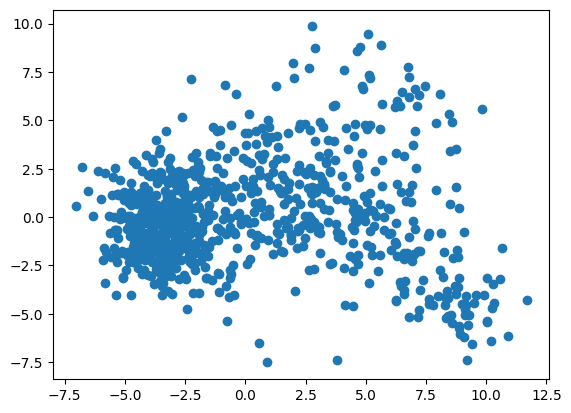

In [84]:
import matplotlib.pyplot as plt
import numpy as np

x = XPCAreduced[:, 0]
y = XPCAreduced[:, 1]

plt.scatter(x, y)
plt.show()